#Importing Data from Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

{}

In [0]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d neuromusic/avocado-prices
!ls

avocado-prices.zip: Skipping, found more recently modified local copy (use --force to force download)
avocado.csv  avocado-prices.zip  kaggle.json  sample_data


In [5]:
!unzip avocado-prices.zip

Archive:  avocado-prices.zip
replace avocado.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: avocado.csv             


#Importing Libraries

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

%matplotlib inline
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
df= pd.read_csv('/content/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [8]:
df.tail()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [9]:
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [11]:
df.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

#Data Exploration

(0.0, 4.0)

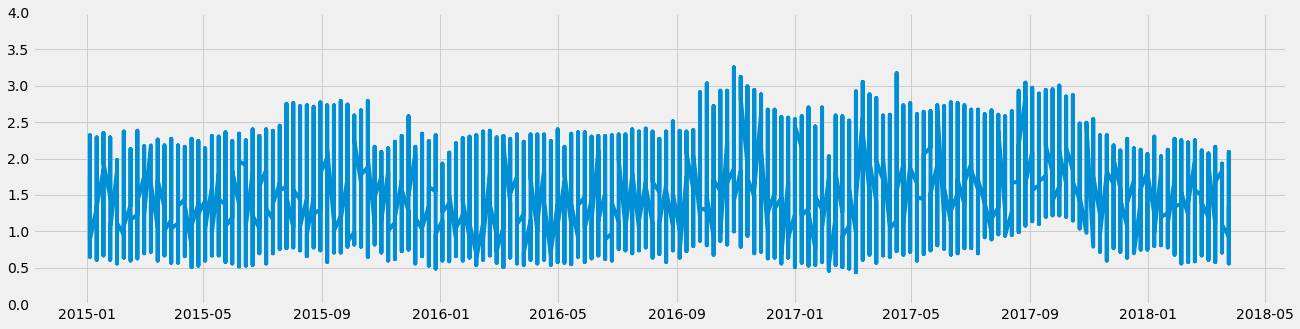

In [13]:
plt.figure(figsize=(20,5))
plt.plot(df['Date'], df['AveragePrice'])
plt.ylim((0,4))

Text(0.5, 1.01, 'Bar Chart to indicate the number of regions')

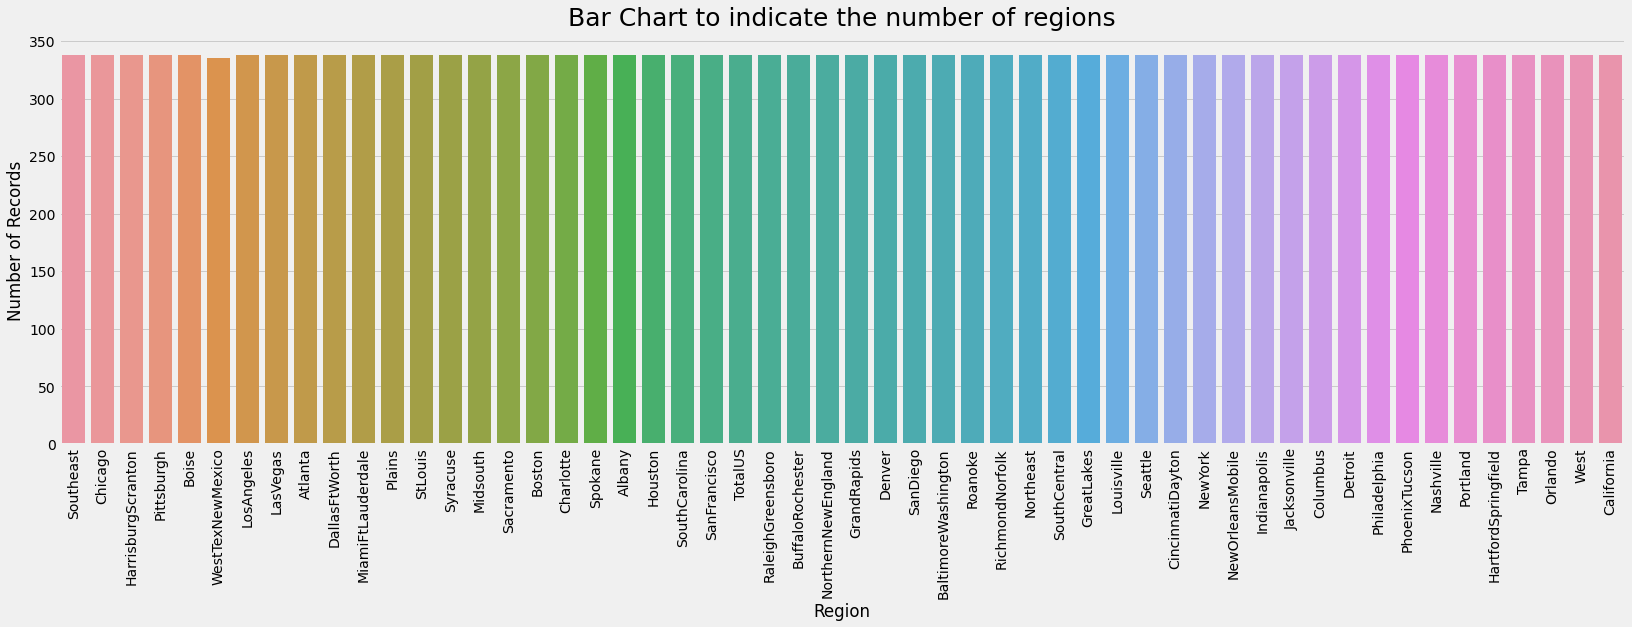

In [14]:
plt.figure(figsize=[25,7])
sns.countplot(x = 'region', data = df)
plt.xticks(rotation = 90)
plt.xlabel('Region')
plt.ylabel('Number of Records')
plt.title('Bar Chart to indicate the number of regions', y = 1.01, fontsize = 25)

Text(0.5, 1.0, ' Bar Chart to show the distribution of records for different Years')

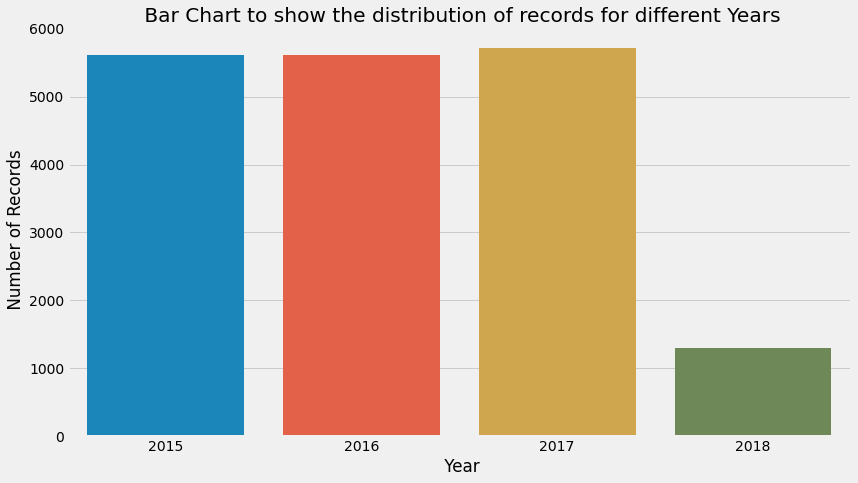

In [15]:
plt.figure(figsize=[12.5,7])
sns.countplot(x = 'year', data = df)
plt.xlabel(' Year')
plt.ylabel(' Number of Records')
plt.title(' Bar Chart to show the distribution of records for different Years')

In [16]:
df.type.value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

# Modeling Time Series with Facebook Prophet

##Price Prediction with Organic Type

In [17]:
organic_df = df[df['type']=='organic']
organic_df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
10009,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
9333,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise
10269,51,2015-01-04,1.50,6329.83,3730.80,2141.91,0.00,457.12,426.67,30.45,0.0,organic,2015,LasVegas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17841,0,2018-03-25,1.75,5518.73,171.22,806.65,3.93,4536.93,2944.89,1592.04,0.0,organic,2018,Jacksonville
18057,0,2018-03-25,1.42,17340.49,295.16,3478.97,81.25,13485.11,12149.49,1335.62,0.0,organic,2018,RichmondNorfolk
17649,0,2018-03-25,1.74,38441.23,27.25,2031.54,0.00,36382.44,29466.95,6915.49,0.0,organic,2018,Boston
18141,0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.0,organic,2018,SouthCentral


([], <a list of 0 Text major ticklabel objects>)

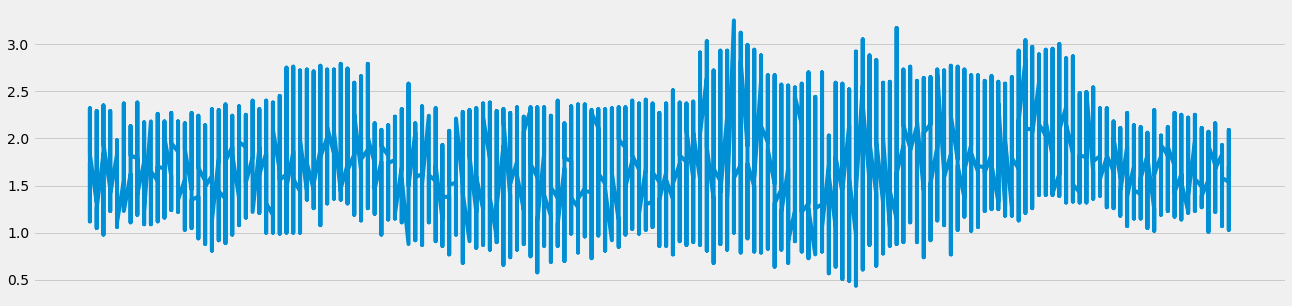

In [18]:
plt.figure(figsize=(20,5))
plt.plot(organic_df['Date'], organic_df['AveragePrice'])
plt.xticks([])

In [0]:
organic_df = organic_df.rename(columns={'Date':'ds', 'AveragePrice':'y'})

In [20]:
m = Prophet()
m.fit(organic_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


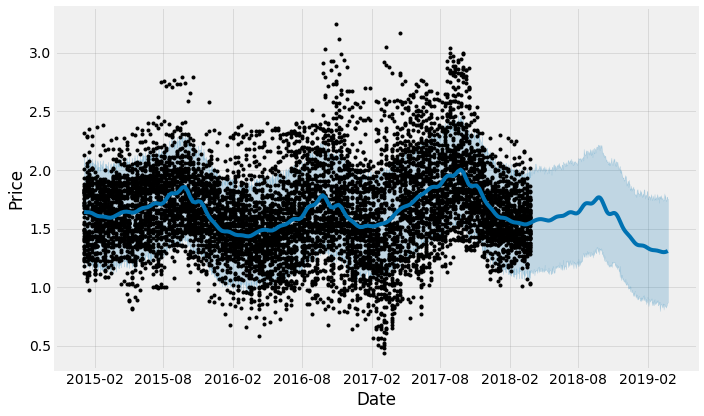

In [21]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

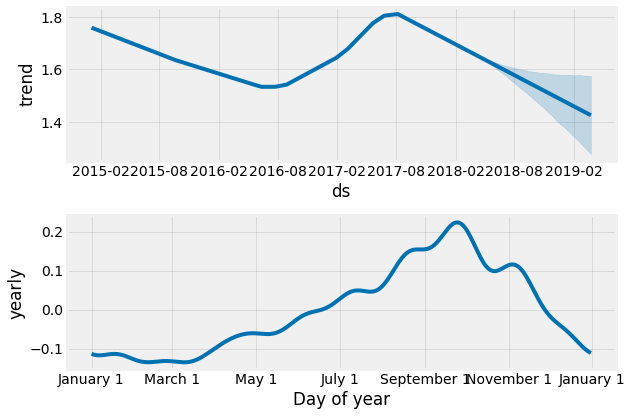

In [22]:
decomposed_figure = m.plot_components(forecast)

##Price Prediction with Conventional Type

In [23]:
conventional_df = df[df['type']=='conventional']
conventional_df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
1819,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
2807,51,2015-01-04,0.75,758118.95,426878.87,147958.43,15267.89,168013.76,165202.22,2811.54,0.00,conventional,2015,WestTexNewMexico
1195,51,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,2015,LosAngeles
103,51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
1143,51,2015-01-04,0.80,317861.35,134003.07,120628.37,4591.23,58638.68,58126.59,512.09,0.00,conventional,2015,LasVegas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8526,0,2018-03-25,1.39,641462.43,26019.52,479186.12,1883.17,134373.62,109938.39,22955.23,1480.00,conventional,2018,Boston
8850,0,2018-03-25,1.32,429132.50,258217.83,25970.97,1426.07,143517.63,90870.28,52357.35,290.00,conventional,2018,Orlando
8574,0,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago
9018,0,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral


([], <a list of 0 Text major ticklabel objects>)

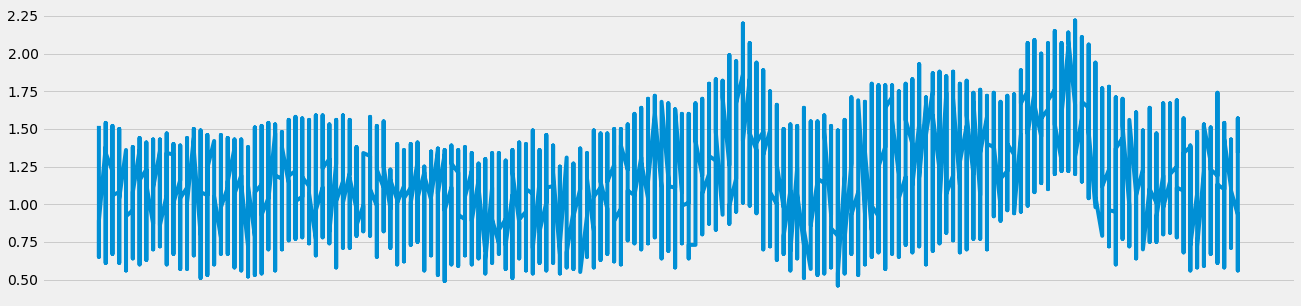

In [24]:
plt.figure(figsize=(20,5))
plt.plot(conventional_df['Date'], conventional_df['AveragePrice'])
plt.xticks([])

In [0]:
conventional_df = conventional_df.rename(columns={'Date':'ds', 'AveragePrice':'y'})

In [26]:
m = Prophet()
m.fit(conventional_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


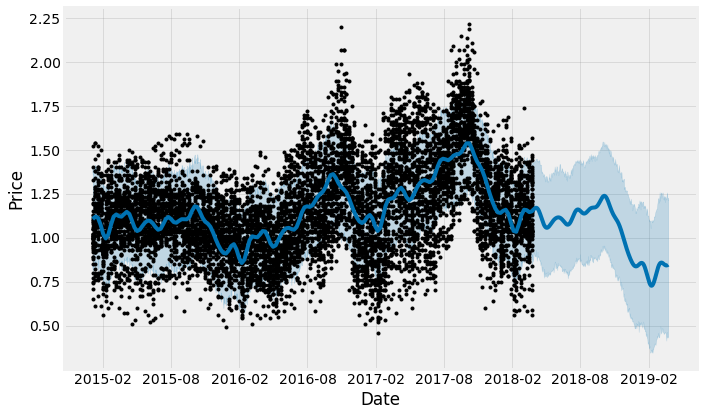

In [27]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

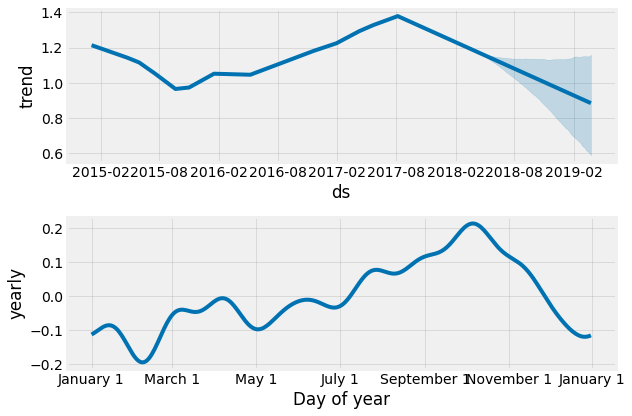

In [28]:
decomposed_figure = m.plot_components(forecast)

##Final Model Prediction 

In [29]:
prophet_df = df[['Date', 'AveragePrice']] 
prophet_df

,Date,AveragePrice
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64
...,...,...
8574,2018-03-25,1.36
9018,2018-03-25,0.70
18141,2018-03-25,1.42
17673,2018-03-25,1.70


In [30]:
prophet_df = prophet_df.rename(columns={'Date':'ds', 'AveragePrice':'y'})
prophet_df

,ds,y
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64
...,...,...
8574,2018-03-25,1.36
9018,2018-03-25,0.70
18141,2018-03-25,1.42
17673,2018-03-25,1.70


In [31]:
m = Prophet()
m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.496497,0.889412,1.859906,1.496497,1.496497,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,0.0,0.0,0.0,1.383903
1,2015-01-04,1.496497,0.894673,1.883291,1.496497,1.496497,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,0.0,0.0,0.0,1.383903
2,2015-01-04,1.496497,0.919369,1.870741,1.496497,1.496497,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,0.0,0.0,0.0,1.383903
3,2015-01-04,1.496497,0.934254,1.861265,1.496497,1.496497,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,0.0,0.0,0.0,1.383903
4,2015-01-04,1.496497,0.929435,1.844291,1.496497,1.496497,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,-0.112593,0.0,0.0,0.0,1.383903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,2019-03-21,1.161789,0.540749,1.579136,0.972961,1.342969,-0.086185,-0.086185,-0.086185,-0.086185,-0.086185,-0.086185,0.0,0.0,0.0,1.075605
18610,2019-03-22,1.161059,0.549712,1.614370,0.971636,1.342912,-0.084525,-0.084525,-0.084525,-0.084525,-0.084525,-0.084525,0.0,0.0,0.0,1.076534
18611,2019-03-23,1.160328,0.571220,1.575489,0.970311,1.342857,-0.082593,-0.082593,-0.082593,-0.082593,-0.082593,-0.082593,0.0,0.0,0.0,1.077735
18612,2019-03-24,1.159597,0.548712,1.617026,0.968987,1.342803,-0.080408,-0.080408,-0.080408,-0.080408,-0.080408,-0.080408,0.0,0.0,0.0,1.079190


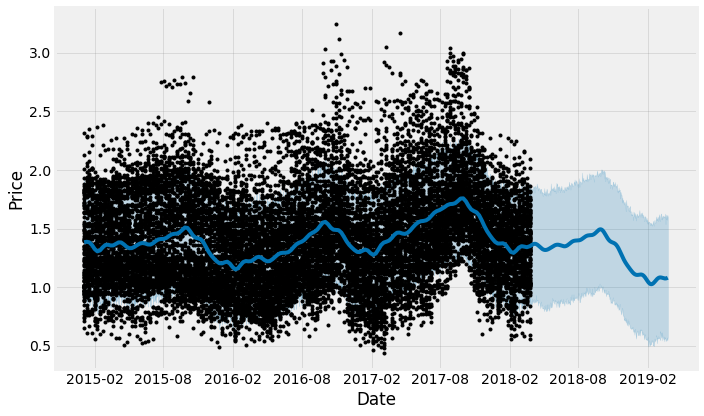

In [33]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

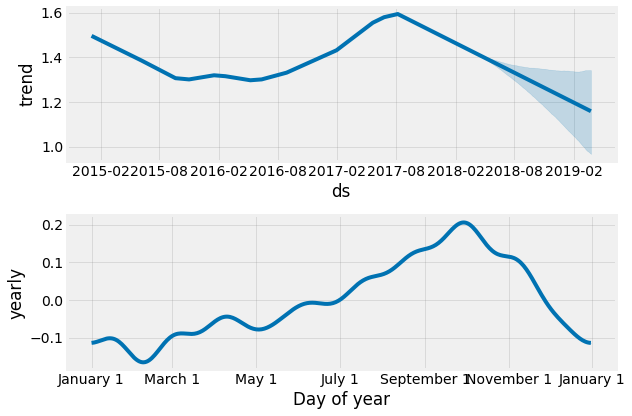

In [34]:
decomposed_figure = m.plot_components(forecast)

In [0]:
predictions = pd.DataFrame(forecast['yhat'])
predictions = predictions.set_index(forecast['trend'])
predictions.to_csv("Avocado Price Prediction_Results.csv" )